In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import networkx as nx
from scipy import linalg
from scipy import sparse as sp
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
data = np.load('./network.npy')

In [3]:
2048/(128*128)

0.125

In [4]:
graph = nx.from_numpy_matrix(data)

In [262]:
from scipy import stats
import tqdm
n = data.shape[0]
len_ = 100
sentences = []

weights_distr = []

for j in range(n):
    weights = []
    for i in range(n):
        try:
            next_ = len(nx.dijkstra_path(graph, j, i))
            if next_ == 1:
                next_ = 1e10
            weights.append(next_)
        except Exception:
            weights.append(1e10)
    xk = np.arange(0, n-1)
    pk = [1/x**10 for x in weights[:-1]]
    pk = pk/np.sum(pk)
    #print (j, pk)
    custm = stats.rv_discrete(a=0, b=127, name='custm', values=(xk, pk))
    weights_distr.append(custm)    

In [213]:
len_ = 1000
for _ in tqdm.tqdm(range(len_)):
    new_sent = [np.random.randint(0, n)]
    sent_size = 200
    for _ in range(sent_size):
        R = weights_distr[new_sent[-1]].rvs(1)
        #print (R)
        new_sent.append(R)
    sentences.append(new_sent)

100%|██████████| 1000/1000 [00:52<00:00, 18.70it/s]


In [214]:
def create_vocabulary(sentences, r=0):
    vocabulary = {}
    temp = {}
    for sent in sentences:
        for word in sent:
            if word in temp:
                temp[word] += 1
            else:
                temp[word] = 1
    iter_ = 0
    for word in temp.keys():            
        if temp[word] >= r:
            vocabulary[word] = iter_
            iter_ += 1
    return vocabulary

In [215]:
vocab = create_vocabulary(sentences)

In [225]:
def create_corpus_matrix(sentences, vocabulary):
    corpus_matrix = np.zeros((len(vocabulary), len(vocabulary)))
    # There was no task not to hardcode window size!!!!!!
    for sent in tqdm.tqdm(sentences):
        for i in range(len(sent)):
            word = sent[i]
            window = sent[max(i-2, 0):i]
            if i != len(sent):
                window = window + sent[i+1:min(len(sent),i+3)]
            for c in window:
                if word in vocabulary and c in vocabulary:
                    corpus_matrix[vocabulary[word], vocabulary[c]] += 1
        
    return corpus_matrix

In [226]:
D = create_corpus_matrix(sentences, vocab)

100%|██████████| 2000/2000 [00:02<00:00, 755.26it/s] 


In [249]:
import scipy.sparse as sparse
import math as m
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

def compute_embeddings(D, k, d=20):
    SPPMI = np.zeros(D.shape)
    D_maj = np.sum(D)
    appearances = np.sum(D, axis=0)
    for i, row in tqdm.tqdm(enumerate(D)):
        word_appearence = np.sum(row)
        for j, element in enumerate(row):
            tolog = D[i,j]*D_maj/(appearances[i]*appearances[j])
            if tolog == 0:
                SPPMI[i, j] = -np.inf
            else:
                SPPMI[i, j] = m.log(tolog)-m.log(k)
            SPPMI[i,j] = max(SPPMI[i, j], 0)
    
    SPPMI_sparse = sparse.csc_matrix(SPPMI, dtype=float) 
    embedding_matrix, s, vt = svds(SPPMI_sparse, k=d)
    embedding_matrix = embedding_matrix[:,::-1]    
    s = np.sqrt(s[::-1])
    s = np.diag(s)
    embedding_matrix = embedding_matrix.dot(s)
    return embedding_matrix

In [244]:
k = 5 # negative sampling parameter
W = compute_embeddings(D, k)

128it [00:00, 605.10it/s]


In [258]:
embed = W

def wL1(a,b):
    return cosine_similarity(a, b)[0]

In [259]:
import random

positive = []
negative = []
adj_dense = data
for i in range(adj_dense.shape[0]):
    for j in range(i, adj_dense.shape[1]):
        if adj_dense[i,j] == 1:
            positive.append((i,j))
        else:
            negative.append((i,j))

positive = np.array(positive)
negative = np.array(negative)
negative = negative[random.sample(range(0, len(negative)), len(positive))]

In [260]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from time import time

features = []
for elem in positive:
    features.append(wL1(embed[elem[0]], embed[elem[1]]))

pos_features = np.array(features)

features = []
for elem in negative:
    features.append(wL1(embed[elem[0]], embed[elem[1]]))

neg_features = np.array(features)

features = np.concatenate((pos_features, neg_features), axis=0)
features.shape

labels = np.concatenate((np.ones(pos_features.shape[0]), np.zeros(neg_features.shape[0])), axis=0)

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

In [261]:
X = features
y = labels
# build a classifier
clf = svm.SVC(gamma='auto')


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


skf = StratifiedKFold(n_splits=3, shuffle=True)

# use a full grid over all parameters
param_grid = {"C": [1, 2, 3, 4],
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid']
             }

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=skf.split(X,y), scoring='roc_auc')
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 10.16 seconds for 16 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.508 (std: 0.011)
Parameters: {'C': 2, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.508 (std: 0.008)
Parameters: {'C': 3, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.506 (std: 0.006)
Parameters: {'C': 4, 'kernel': 'rbf'}



In [267]:
tmp = []
for i in range(120):
    for j in range(i+1, 120):
        tmp.append(cosine_similarity(W[i], W[j])[0][0])

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

(array([  22.,  215.,  990., 1767., 1908., 1283.,  663.,  241.,   45.,
           6.]),
 array([-0.41342733, -0.28366064, -0.15389395, -0.02412726,  0.10563943,
         0.23540611,  0.3651728 ,  0.49493949,  0.62470618,  0.75447287,
         0.88423956]),
 <a list of 10 Patch objects>)

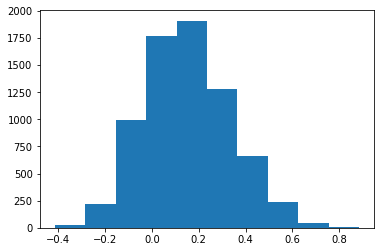

In [268]:
plt.hist(tmp)